In [79]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import pyqg.diagnostic_tools
%matplotlib inline
import os

from dask.diagnostics import ProgressBar

In [92]:
# Imports auxiliary functions
import importlib
import StrucFunction
importlib.reload(StrucFunction)
from StrucFunction import *

# Runs Two-layer QG Model

The model configuration is similar to the high-resolution eddy configuration of \cite{ross2022}, which generates a field of isotropic eddies. The configuration is a flat bottom doubly periodic square domain of size $L_x =L_y=1000$ km, with $n_x=n_y=256$ corresponding to a uniform grid spacing of $\sim 3.9$ km. The simulation is forced with a mean vertical shear, set by $U_1=0.025$ m s$^{-1}$ and $U_2=0$ in the top and bottom layer of mean thicknesses $H_1=500$ m and $H_2=2000$ m. Layer densities are chosen such that the Rossby radius $r_d=15$~km (characteristic of high-latitude environments), which is large enough to be well resolved on the chosen grid. Also, $\beta=1.5 \times 10^{-11}$ m$^{-1}$ s$^{-1}$ and  bottom drag is $r_{ek}=5.787 \times 10^{-7}$ s$^{-1}$. The model is spun up for five years and run for 15 years with a time step of 1 hr. For computational convenience, we saved and used daily averaged horizontal velocity fields. We only used the model's upper layer. 

In [3]:
def run_simulation(m, sampling_freq):
    """
    m: pyqg model object
    sampling_freq: frequency in numerical timesteps in which to extract dataset
    """
    snapshots = []
    while eddy_model.t < eddy_model.tmax:
        if eddy_model.tc % sampling_freq == 0:
            ds=eddy_model.to_dataset().copy(deep=True)
            snapshots.append(ds)
        eddy_model._step_forward()
    return snapshots

In [ ]:
# Run with snapshots
year = 24*60*60*360. #seconds

eddy_model = pyqg.QGModel(nx=256.0,dt=3600.0, tmax=20*year, ntd=1,twrite=10000, 
                          tavestart=155520000.0, taveint= 86400, 
                          beta=1.5e-11, rd=15000.0, delta=0.25, 
                          H1=500, U1=0.025, U2=0.0)

# Saves snapshots
snaps=run_simulation(eddy_model, 24) # Saves data 
# Convert to xarray data 
eddyrun_lev = xr.concat(snaps, dim='time')

snap_index=-1
cmap="bwr"
plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
plt.title("q")
plt.imshow(snaps[snap_index].q[0][0],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(snaps[snap_index].q[0][1],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,2)
plt.title("u")
plt.imshow(snaps[snap_index].u[0][0],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(snaps[snap_index].u[0][1],cmap=cmap)
plt.colorbar()

plt.subplot(2,3,3)
plt.title("v")
plt.imshow(snaps[snap_index].v[0][0],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(snaps[snap_index].v[0][1],cmap=cmap)
plt.colorbar()

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.37e-06, CFL: 0.024
INFO: Step: 20000, Time: 7.20e+07, KE: 2.02e-04, CFL: 0.077
INFO: Step: 30000, Time: 1.08e+08, KE: 6.46e-04, CFL: 0.244
INFO: Step: 40000, Time: 1.44e+08, KE: 6.33e-04, CFL: 0.254
INFO: Step: 50000, Time: 1.80e+08, KE: 6.21e-04, CFL: 0.244
INFO: Step: 60000, Time: 2.16e+08, KE: 6.11e-04, CFL: 0.220
INFO: Step: 70000, Time: 2.52e+08, KE: 5.81e-04, CFL: 0.238
INFO: Step: 80000, Time: 2.88e+08, KE: 5.70e-04, CFL: 0.232
INFO: Step: 90000, Time: 3.24e+08, KE: 5.90e-04, CFL: 0.205
INFO: Step: 100000, Time: 3.60e+08, KE: 5.80e-04, CFL: 0.233
INFO: Step: 110000, Time: 3.96e+08, KE: 6.04e-04, CFL: 0.203
INFO: Step: 120000, Time: 4.32e+08, KE: 6.18e-04, CFL: 0.207
INFO: Step: 130000, Time: 4.68e+08, KE: 5.98e-04, CFL: 0.210
INFO: Step: 140000, Time: 5.04e+08, KE: 5.40e-04, CFL: 0.213
INFO: Step: 150000, Time: 5.40e+08, KE: 5.93e-04, CFL: 0.225
INFO: Step: 160000, Time: 5.76e+08, KE: 6.03e-04, CFL: 0.241
INFO: S

In [ ]:
# Removes some variables and saves data
delvar = ["qh", "uh", "vh", "ph",
          "dqhdt", "Ubg", "Qy", "dqdt",
          "p", "ufull", "vfull"]
eddyrun_lev = eddyrun_lev.drop_vars(delvar)

eddyrun_lev.to_netcdf('/data/SO3/manuelogv/MethodsKEFlux/QGModelRun20years.nc')

### Use line below if kernel dies

In [78]:
# Load data
fileQG = '/data/SO3/manuelogv/MethodsKEFlux/QGModelRun20years.nc'

eddyrun_lev = xr.open_dataset(fileQG)

eddyrun_lev = eddyrun_lev.rename({"x": "XC", "y": "YC"})

## Calculates first-, second-, and third-order velocity fluctuations

#### estimation of two-point differences in scalars or vectors, such as velocity differences:

\begin{equation}
\delta \mathbf{u}(\mathbf{s},\mathbf{r}, t) = \mathbf{u}(\mathbf{s} + \mathbf{r}, t) - \mathbf{u}(\mathbf{s}, t),\label{eq1}    
\end{equation}

where $\delta \mathbf{u}$ represents the velocity difference between two points $\mathbf{s}$ and $\mathbf{s} + \mathbf{r}$ separated by the vector $\mathbf{r}$ at time $t$. These velocity differences are the central focus of this study. To avoid reliance on fixed geographical coordinates, we decompose $\delta \mathbf{u}$ into longitudinal and transverse components $\mathbf{\delta u}=(\delta u_{L}, \delta u_{T})$:

\begin{equation}
    \delta u_{L}=\delta \mathbf{u}\cdot\frac{\mathbf{r}}{|\mathbf{r}|},\ \ \ \
    \delta u_{T}=\frac{\mathbf{\widehat{z}}\cdot(\delta \mathbf{u}\times \mathbf{r})}{|\mathbf{r}|}, \label{eq2}
\end{equation}

where $\mathbf{\widehat{\mathbf{z}}}$ is the vertical unit vector.

In [20]:
# Calculates structure functions
shiftdim = 'XC','XC'
maxcorr = 20
grid = 'm'

# rbins = np.arange(1e3, 2e5, 4e3)

# Gets last five years of data
nyears = 5
yr = 365

i1 = -2-yr*nyears
time3y = np.arange(i1, i1 + yr*nyears)

In [21]:
# Chunks data

chx = len(eddyrun_lev.XC)
chy = len(eddyrun_lev.YC)
cht = len(eddyrun_lev.time)

chunks = {'XC': chx, 'YC': chy, 'time': cht}

Udsn = eddyrun_lev.isel(lev=0, time=time3y).chunk(chunks)
Udsn

<xarray.Dataset>
Dimensions:  (time: 1825, YC: 256, XC: 256, lev_mid: 1, l: 256, k: 129)
Coordinates:
  * time     (time) float64 4.642e+08 4.643e+08 ... 6.217e+08 6.218e+08
    lev      int64 1
  * lev_mid  (lev_mid) float64 1.5
  * XC       (XC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * YC       (YC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * l        (l) float64 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float64 0.0 6.283e-06 1.257e-05 ... 0.000798 0.0008042
Data variables:
    q        (time, YC, XC) float64 dask.array<chunksize=(1825, 256, 256), meta=np.ndarray>
    u        (time, YC, XC) float64 dask.array<chunksize=(1825, 256, 256), meta=np.ndarray>
    v        (time, YC, XC) float64 dask.array<chunksize=(1825, 256, 256), meta=np.ndarray>
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       622080000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

### Code for estimating $\delta u(\mathbf{s}, \mathbf{r}, t)$, $\delta u2(\mathbf{s}, \mathbf{r}, t)$, and $\delta u3(\mathbf{s}, \mathbf{r}, t)$.

$\mathbf{s} \rightarrow$  all positions

$\mathbf{r} \rightarrow$  all separations and orientations

In [93]:
# Max corr (grid points) and max dist (meters)
maxcorr = 120
maxdist = 100e3

# Parameters
chunk_size = 5
max_time = 200
zarr_path = "/data/SO3/manuelogv/MethodsKEFlux/rawduLT/SFtest_results.zarr"
per=True # True if double periodic
grid='m'

# Make sure the output file is fresh
import shutil, os
if os.path.exists(zarr_path):
    shutil.rmtree(zarr_path)

# Process in chunks
with ProgressBar():
    for start in range(0, max_time, chunk_size):
        end = min(start + chunk_size, max_time)

        # Run the structure function calculation
        SF_chunk = calculateSF_2(Udsn.u.isel(time=np.arange(start, end)),
                                 Udsn.v.isel(time=np.arange(start, end)),
                                 maxcorr, shiftdim, maxdist, grid, periodic=per,
                                 aver_spat=False, sf2_3=True)

        # # Convert to xarray Dataset if needed
        # if not isinstance(SF_chunk, xr.Dataset):
        #     SF_chunk = xr.Dataset(SF_chunk)

        # Append to Zarr file
        if start == 0:
            # Write the first chunk, initialize the zarr store
            SF_chunk.to_zarr(zarr_path, mode="w", consolidated=True)
        else:
            # Append along the time dimension
            SF_chunk.to_zarr(zarr_path, mode="a", append_dim="time", consolidated=True)


[########################################] | 100% Completed | 101.35 ms
[########################################] | 100% Completed | 101.05 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 257.03 s
[########################################] | 100% Completed | 102.00 ms
[########################################] | 100% Completed | 100.87 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 135.25 s
[########################################] | 100% Completed | 102.95 ms
[########################################] | 100% Completed | 101.41 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 151.69 s
[########################################] | 100% Completed | 104.15 ms
[########################################] | 100% Completed | 100.72 ms
Calculating pairwise velocity differences
[########################################] 

In [98]:
SF_chunk

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, time: 5, dcorr: 2060)
Coordinates:
    lev      int64 1
  * XC       (XC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * YC       (YC) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * time     (time) float64 4.811e+08 4.812e+08 4.812e+08 4.813e+08 4.814e+08
  * dcorr    (dcorr) float64 9.92e+04 9.851e+04 9.797e+04 ... 9.851e+04 9.92e+04
Data variables:
    dr       (dcorr, XC, YC, time) float64 9.504e+04 9.504e+04 ... 9.504e+04
    ulls     (dcorr, XC, YC, time) float64 -0.128 -0.1261 ... -0.05268 -0.04997
    utts     (dcorr, XC, YC, time) float64 0.06113 0.06182 ... -0.06714 -0.06712
    theta    (dcorr, XC, YC, time) float64 -2.976 -2.976 ... 0.1651 0.1651
    dul2     (dcorr, XC, YC, time) float64 0.01638 0.01589 ... 0.002775 0.002497
    dut2     (dcorr, XC, YC, time) float64 0.003737 0.003822 ... 0.004505
    du3      (dcorr, XC, YC, time) float64 -0.002575 -0.002485 ... -0.0003499

Size of Xarray Dataset = 10 GB


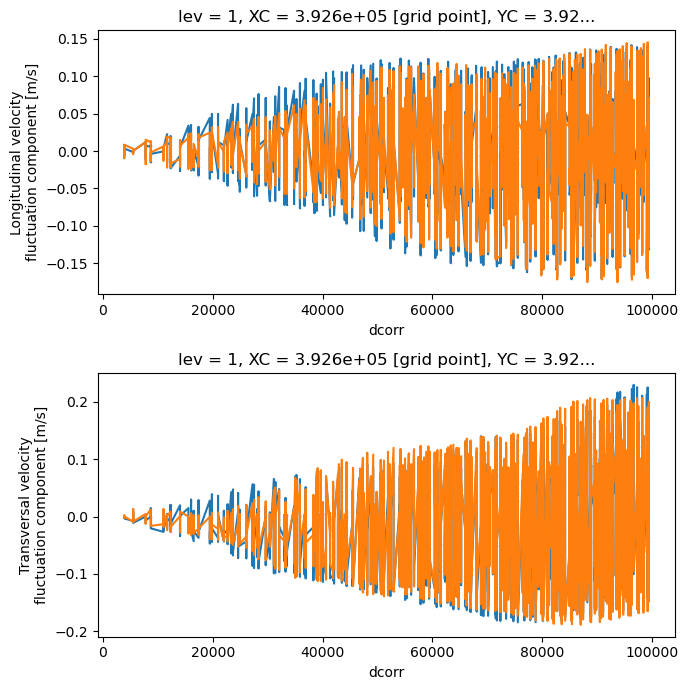

In [105]:
print('Size of Xarray Dataset = ' + str(int(SFtest.nbytes/1e9)) + ' GB')

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
SF_chunk.ulls.isel(XC=100, YC=100, time=0).sortby('dcorr').plot(marker='.', markersize=0.15)
SF_chunk.ulls.isel(XC=100, YC=100, time=4).sortby('dcorr').plot(marker='.', markersize=0.15)
# SFtest.ulls.isel(x=200, y=100, time=14).plot()

plt.subplot(2, 1, 2)
SF_chunk.utts.isel(XC=100, YC=100, time=0).sortby('dcorr').plot(marker='.', markersize=0.15)
SF_chunk.utts.isel(XC=100, YC=100, time=4).sortby('dcorr').plot(marker='.', markersize=0.15)
# SFtest.utts.isel(x=200, y=100, time=14).plot()

plt.tight_layout()

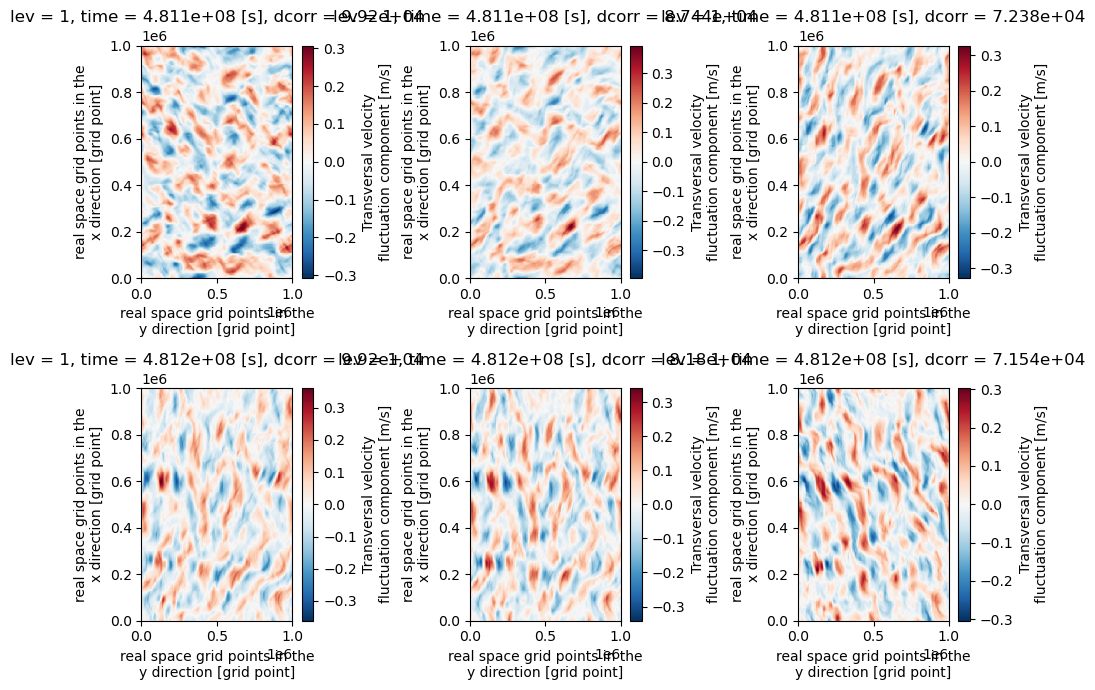

In [100]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
SF_chunk.utts.isel(time=0, dcorr=0).plot()

plt.subplot(2, 3, 2)
SF_chunk.utts.isel(time=0, dcorr=100).plot()

plt.subplot(2, 3, 3)
SF_chunk.utts.isel(time=0, dcorr=500).plot()

plt.subplot(2, 3, 4)
SF_chunk.utts.isel(time=1, dcorr=800).plot()

plt.subplot(2, 3, 5)
SF_chunk.utts.isel(time=1, dcorr=1000).plot()

plt.subplot(2, 3, 6)
SF_chunk.utts.isel(time=1, dcorr=1400).plot()

plt.tight_layout()

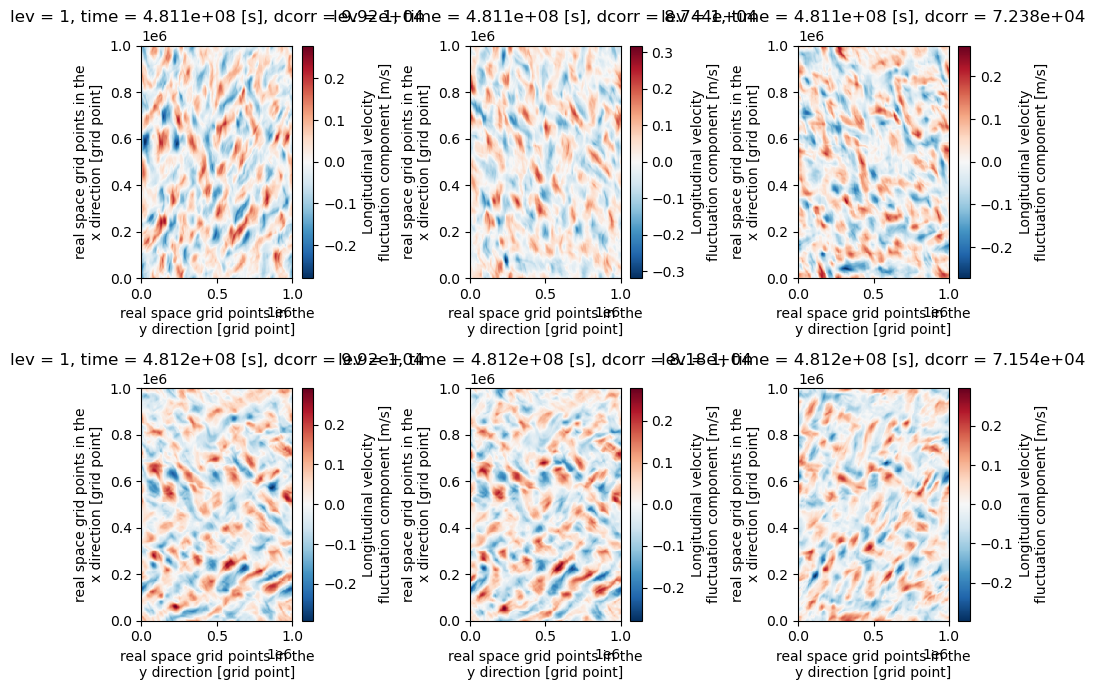

In [101]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
SF_chunk.ulls.isel(time=0, dcorr=0).plot()

plt.subplot(2, 3, 2)
SF_chunk.ulls.isel(time=0, dcorr=100).plot()

plt.subplot(2, 3, 3)
SF_chunk.ulls.isel(time=0, dcorr=500).plot()

plt.subplot(2, 3, 4)
SF_chunk.ulls.isel(time=1, dcorr=800).plot()

plt.subplot(2, 3, 5)
SF_chunk.ulls.isel(time=1, dcorr=1000).plot()

plt.subplot(2, 3, 6)
SF_chunk.ulls.isel(time=1, dcorr=1400).plot()

plt.tight_layout()

In [30]:
# Runs code for all datasets
time_indices = np.arange(len(Udsn.time))  # All time indices

# Max corr (grid points) and max dist (meters)
maxcorr = 120
maxdist = 320e3

data = Udsn.isel(time=np.arange(0, 2)).chunk()

In [33]:
# Runs code
with ProgressBar():
    SFQG = calculateSF_2aver_exc(data.u, data.v, maxcorr, shiftdim, maxdist, grid, periodic=per)

[########################################] | 100% Completed | 101.15 ms
[########################################] | 100% Completed | 101.20 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 11m 10s
Concatenate
Done


In [34]:
print(SFQG.nbytes/1e9)
SFQG

0.002527704


<xarray.Dataset>
Dimensions:  (time: 2, dcorr: 21064)
Coordinates:
    lev      int64 1
  * time     (time) float64 4.642e+08 4.643e+08
  * dcorr    (dcorr) float64 -2.995 -3.007 -3.019 -3.031 ... 0.1228 0.135 0.1471
Data variables:
    dr       (dcorr, time) float64 3.186e+05 3.186e+05 ... 3.186e+05 3.186e+05
    ulls     (dcorr, time) float64 1.71e-06 1.75e-06 ... 1.71e-06 1.75e-06
    utts     (dcorr, time) float64 4.097e-06 4.291e-06 ... 4.097e-06 4.291e-06
    theta    (dcorr, time) float64 -2.995 -2.995 -3.007 ... 0.135 0.1471 0.1471
    dul2     (dcorr, time) float64 0.005133 0.005151 ... 0.005133 0.005151
    dut2     (dcorr, time) float64 0.004719 0.004721 ... 0.004719 0.004721
    du3      (dcorr, time) float64 -8.781e-05 -9.294e-05 ... -9.294e-05

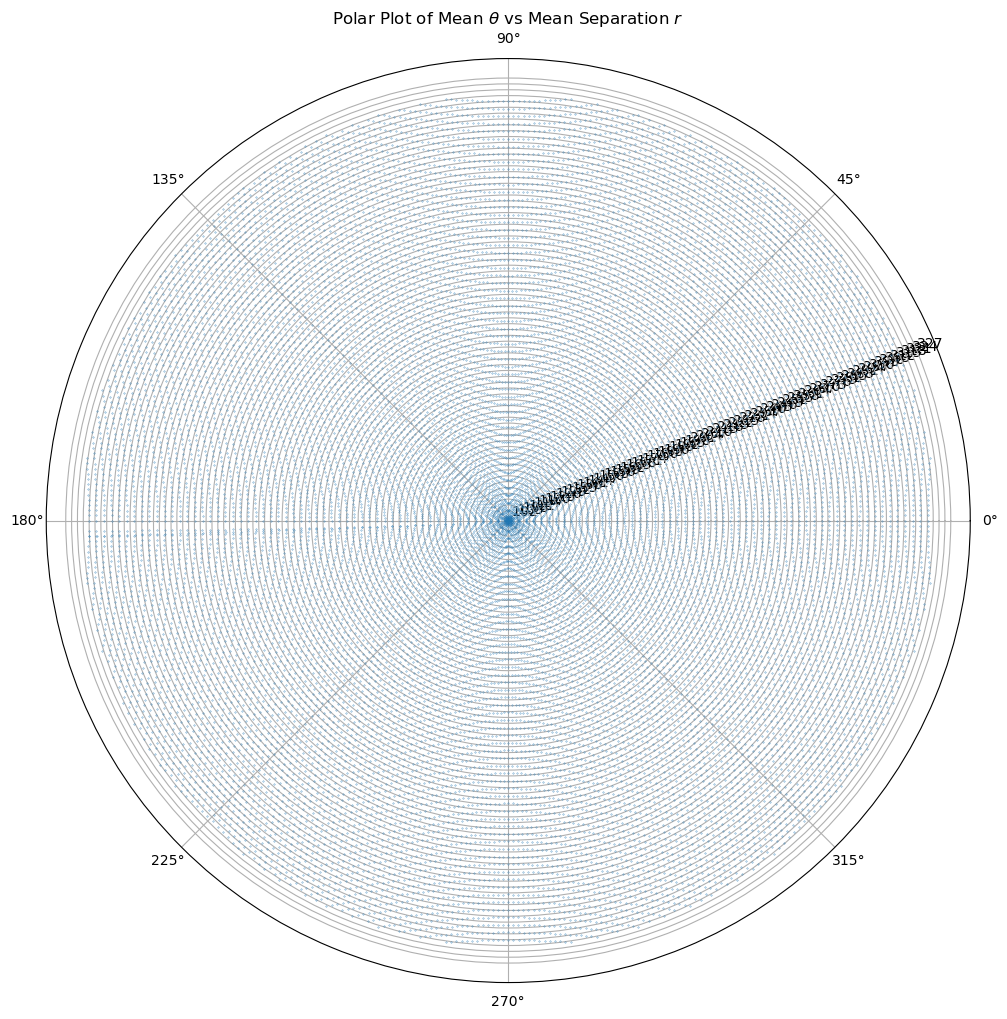

In [37]:
# Polar plot
plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection='polar')

# Plotting data
ax.plot(
    SFQG.theta.mean(dim=('time')), 
    SFQG.dr.mean(dim=('time')) * 1e-3, 
    '.', 
    markersize=0.5, 
    alpha=1
)

# Add more radial ticks (in km)
radial_ticks = np.arange(0, SFQG.dr.mean(dim='time').max().item() * 1e-3 + 10, 3)  # every 10 km
ax.set_rgrids(radial_ticks, angle=22.5)  # optional: control the label angle

# Set radial limit
ax.set_rlim(100, radial_ticks[-1]+10)

ax.set_title('Polar Plot of Mean $\\theta$ vs Mean Separation $r$')
plt.show()


In [41]:
# chunk_size = 500

# # Total number of time steps
# nt = Udsn.sizes['time']
# n_chunks = (nt + chunk_size - 1) // chunk_size

# os.makedirs(zarr_path, exist_ok=True)

# t_start = 1 * chunk_size
# t_end = min((1 + 1) * chunk_size, nt)

# ue_chunk = Udsn.u.isel(time=slice(t_start, t_end)).chunk({'time': 200})
# ue_chunk

# Estimating $\delta u1$, $\delta u2$ and $\delta u3$

Here we defined the samples of first-, second-, and third-order structure function for stationary, homogeneous and isotropic flows as:

\begin{equation}
     \delta u1 = \delta u_{L}(\mathbf{s},\mathbf{r}, t) + \delta u_{T}(\mathbf{s},\mathbf{r}, t). 
\end{equation}

Similarly, the samples of the second-order structure are defined as,

\begin{align}
    \delta u2_L & = \delta u^2_{L}(\mathbf{s},\mathbf{r}, t)\\
    \delta u2_T & = \delta u^2_{T}(\mathbf{s},\mathbf{r}, t), 
\end{align}


and for the third-order:

\begin{equation}
    \delta u3 = \delta u_{L}(\mathbf{s},\mathbf{r}, t)[\delta u^2_{L}(\mathbf{s},\mathbf{r}, t) + \delta u^2_{T}(\mathbf{s},\mathbf{r}, t)].
\end{equation}

Code first calculates samples of structure functions and then averaged them by all positions $\mathbf{s}$. The code then yields $\delta u(\mathbf{r}, t)$, $\delta u2(\mathbf{r}, t)$, and $\delta u3(\mathbf{r}, t)$.

In [43]:
# Saves files into zarr
import os
from tqdm import tqdm

zarr_path = '/data/SO3/manuelogv/MethodsKEFlux/QGSF_averXY/SFaver_QG.zarr'

chunk_size = 50
chunktime = 50

# Total number of time steps
nt = Udsn.sizes['time']
n_chunks = (nt + chunk_size - 1) // chunk_size

os.makedirs(zarr_path, exist_ok=True)

for i in tqdm(range(n_chunks), desc='Computing chunk'):
    t_start = i * chunk_size
    t_end = min((i + 1) * chunk_size, nt)

    ue_chunk = Udsn.u.isel(time=slice(t_start, t_end)).chunk({'time': chunktime})
    ve_chunk = Udsn.v.isel(time=slice(t_start, t_end)).chunk({'time': chunktime})


    with ProgressBar():
        SF_chunk = calculateSF_2aver_exc(ue_chunk, ve_chunk, 
                                         maxcorr, shiftdim, maxdist, grid, periodic=per)

    # Add metadata
    SF_chunk.attrs.update({
        'chunk_index': i,
        'time_start': str(ue_chunk.time.values[0]),
        'time_end': str(ue_chunk.time.values[-1]),
        'source': 'run_chunked_structure_functions',
        'maxcorr': maxcorr,
        'grid': grid,
        'max_dist_m': maxdist
    })

    # Save or append to Zarr
    if i == 0:
        # First chunk: write without append_dim
        with ProgressBar():
            SF_chunk.to_zarr(zarr_path, mode='w', consolidated=True)
    else:
        # Subsequent chunks: append along time
        with ProgressBar():
            SF_chunk.to_zarr(zarr_path, mode='a', append_dim='time', 
                             consolidated=True)
    # filessv = '/data/SO3/manuelogv/MethodsKEFlux/rawduLT/' + str(start)
    # SFQG.to_zarr(filesv)

Computing chunk:   0%|                              | 0/37 [00:00<?, ?it/s]

[########################################] | 100% Completed | 101.22 ms
[########################################] | 100% Completed | 100.95 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 45m 42s
Concatenate
Done


Computing chunk:   3%|▍                | 1/37 [47:48<28:41:23, 2868.99s/it]

[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 100.75 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 41m 37s
Concatenate
Done


Computing chunk:   5%|▊              | 2/37 [1:31:26<26:27:17, 2721.08s/it]

[########################################] | 100% Completed | 102.24 ms
[########################################] | 100% Completed | 101.06 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 37m 58s
Concatenate
Done


Computing chunk:   8%|█▏             | 3/37 [2:11:24<24:18:23, 2573.65s/it]

[########################################] | 100% Completed | 101.37 ms
[########################################] | 100% Completed | 100.96 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 46m 40s
Concatenate
Done


Computing chunk:  11%|█▌             | 4/37 [3:00:31<24:56:26, 2720.81s/it]

[########################################] | 100% Completed | 311.35 ms
[########################################] | 100% Completed | 139.51 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 63m 31s
Concatenate
Done


Computing chunk:  14%|██             | 5/37 [4:07:51<28:24:56, 3196.75s/it]

[########################################] | 100% Completed | 125.96 ms
[########################################] | 100% Completed | 101.09 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 71m 24s
Concatenate
Done


Computing chunk:  16%|██▍            | 6/37 [5:22:06<31:12:38, 3624.47s/it]

[########################################] | 100% Completed | 173.71 ms
[########################################] | 100% Completed | 101.02 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 42m 41s
Concatenate
Done


Computing chunk:  19%|██▊            | 7/37 [6:06:46<27:37:45, 3315.53s/it]

[########################################] | 100% Completed | 101.17 ms
[########################################] | 100% Completed | 100.87 ms
Calculating pairwise velocity differences
[##############################          ] | 75% Completed | 16m 8sss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[####################################    ] | 91% Completed | 30m 54s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 39m 57s
Concatenate
Done


Computing chunk:  62%|████████▋     | 23/37 [17:19:02<9:45:28, 2509.16s/it]

[########################################] | 100% Completed | 101.62 ms
[########################################] | 100% Completed | 101.01 ms
Calculating pairwise velocity differences
[#######################                 ] | 59% Completed | 173.47 s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 45m 24s
Concatenate
Done


Computing chunk:  68%|█████████▍    | 25/37 [18:50:52<8:48:28, 2642.37s/it]

[########################################] | 100% Completed | 101.28 ms
[########################################] | 100% Completed | 101.30 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 41m 29s
Concatenate
Done


Computing chunk:  70%|█████████▊    | 26/37 [19:34:17<8:02:21, 2631.05s/it]

[########################################] | 100% Completed | 101.27 ms
[########################################] | 100% Completed | 100.83 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 42m 3ss
Concatenate
Done


Computing chunk:  73%|██████████▏   | 27/37 [20:18:11<7:18:40, 2632.09s/it]

[########################################] | 100% Completed | 101.20 ms
[########################################] | 100% Completed | 101.06 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 41m 12s
Concatenate
Done


Computing chunk:  76%|██████████▌   | 28/37 [21:01:22<6:32:56, 2619.58s/it]

[########################################] | 100% Completed | 101.26 ms
[########################################] | 100% Completed | 100.80 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 44m 39s
Concatenate
Done


Computing chunk:  78%|██████████▉   | 29/37 [21:47:51<5:56:03, 2670.40s/it]

[########################################] | 100% Completed | 101.14 ms
[########################################] | 100% Completed | 101.06 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 39m 52s
Concatenate
Done


Computing chunk:  81%|███████████▎  | 30/37 [22:29:38<5:05:49, 2621.39s/it]

[########################################] | 100% Completed | 137.52 ms
[########################################] | 100% Completed | 100.92 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 41m 8ss
Concatenate
Done


Computing chunk:  84%|███████████▋  | 31/37 [23:12:43<4:21:04, 2610.70s/it]

[########################################] | 100% Completed | 101.54 ms
[########################################] | 100% Completed | 100.81 ms
Calculating pairwise velocity differences
[########################################] | 100% Completed | 40m 35s
Concatenate
Done


Computing chunk:  86%|████████████  | 32/37 [23:55:09<3:35:56, 2591.21s/it]

[########################################] | 100% Completed | 101.13 ms
[########################################] | 100% Completed | 100.72 ms
Calculating pairwise velocity differences
[#################################       ] | 82% Completed | 27m 14ss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [44]:
SF_chunk

<xarray.Dataset>
Dimensions:  (time: 25, dcorr: 21064)
Coordinates:
    lev      int64 1
  * time     (time) float64 6.197e+08 6.198e+08 ... 6.217e+08 6.218e+08
  * dcorr    (dcorr) float64 -2.995 -3.007 -3.019 -3.031 ... 0.1228 0.135 0.1471
Data variables:
    dr       (dcorr, time) float64 3.186e+05 3.186e+05 ... 3.186e+05 3.186e+05
    ulls     (dcorr, time) float64 1.524e-06 1.401e-06 ... -1.457e-07 -8.849e-08
    utts     (dcorr, time) float64 1.377e-05 1.348e-05 ... 4.615e-06 4.71e-06
    theta    (dcorr, time) float64 -2.995 -2.995 -2.995 ... 0.1471 0.1471 0.1471
    dul2     (dcorr, time) float64 0.006178 0.006248 ... 0.007094 0.007027
    dut2     (dcorr, time) float64 0.00627 0.006274 ... 0.005915 0.005894
    du3      (dcorr, time) float64 3.747e-05 3.572e-05 ... -5.963e-06 -8.432e-06
Attributes:
    chunk_index:  36
    time_start:   619747200.0
    time_end:     621820800.0
    source:       run_chunked_structure_functions
    maxcorr:      120
    grid:         m
    max_dist_m:   320000.0

# Loads zarr file and chunks it

In [45]:
import pandas as pd

zarr_path = '/data/SO3/manuelogv/MethodsKEFlux/QGSF_averXY/SFaver_QG.zarr/'
du_qg = xr.open_zarr(zarr_path, consolidated=True)
du_qg = du_qg.chunk({'dcorr': 541*4, 'time':365*2})

du_qg = du_qg.assign_coords(time=pd.to_datetime(du_qg.time.values, unit='s'))

In [46]:
du_qg

<xarray.Dataset>
Dimensions:  (dcorr: 21064, time: 1825)
Coordinates:
  * dcorr    (dcorr) float64 -2.995 -3.007 -3.019 -3.031 ... 0.1228 0.135 0.1471
    lev      int64 ...
  * time     (time) datetime64[ns] 1984-09-17 1984-09-18 ... 1989-09-15
Data variables:
    dr       (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    du3      (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    dul2     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    dut2     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    theta    (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    ulls     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
    utts     (dcorr, time) float64 dask.array<chunksize=(2164, 730), meta=np.ndarray>
Attributes:
    chunk_index:  36
    grid:         m
    max_dist_m:   320000.0
    maxcorr:      120
    source:       run_chunked_structure_functions
    time_end:     621820800.0
    time_start:   619747200.0

/tmp/ipykernel_3232067/1188333543.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(du_qg.dr*1e-3, nt.T/365, du_qg.du3, cmap='bwr', vmin=-0.0002, vmax=0.0002)


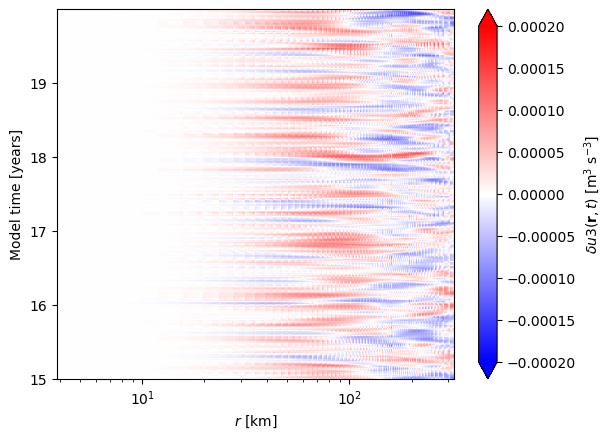

In [47]:
_, nt = np.meshgrid(du_qg.dcorr, np.arange(0, len(du_qg.time))+(15*365))
plt.pcolormesh(du_qg.dr*1e-3, nt.T/365, du_qg.du3, cmap='bwr', vmin=-0.0002, vmax=0.0002)
cb1 = plt.colorbar(extend='both')
plt.xscale('log')
plt.xlabel('$r$ [km]')
plt.ylabel('Model time [years]')
cb1.set_label('$\\delta u3(\\mathbf{r}, t)$ [m$^3$ s$^{-3}$]')

Text(0, 0.5, '$\\delta u3(\\mathbf{r})$ [m$^3$ s$^{-3}$]')

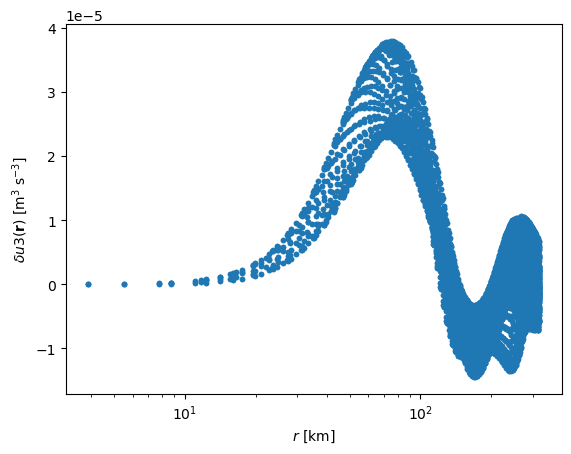

In [48]:
plt.semilogx(du_qg.dr.mean('time')*1e-3, du_qg.du3.mean('time'), '.')
plt.xlabel('$r$ [km]')
plt.ylabel('$\\delta u3(\\mathbf{r})$ [m$^3$ s$^{-3}$]')

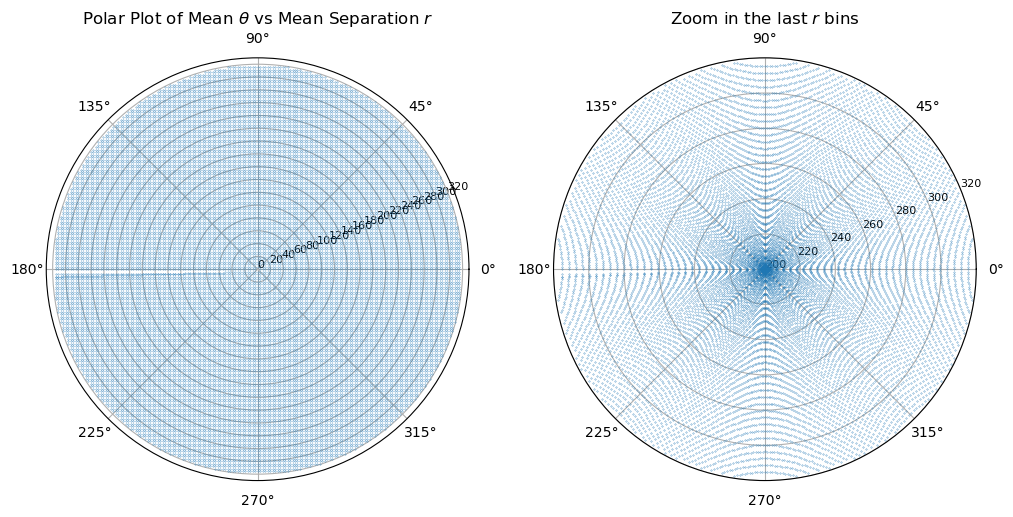

In [49]:
# Polar plot
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(121, projection='polar')

# Plotting data
ax1.plot(
    du_qg.theta.mean(dim=('time')), 
    du_qg.dr.mean(dim=('time')) * 1e-3, 
    '.', 
    markersize=0.5, 
    alpha=1
)

# Add more radial ticks (in km)
radial_ticks = np.arange(0, du_qg.dr.mean(dim='time').max() * 1e-3 + 10, 20)  # every x km
ax1.set_rgrids(radial_ticks, angle=22.5, fontsize=8)  # optional: control the label angle

# Set radial limit
ax1.set_rlim(0, radial_ticks[-1]+10)
ax1.set_title('Polar Plot of Mean $\\theta$ vs Mean Separation $r$')

ax2 = plt.subplot(122, projection='polar')

# Plotting data
ax2.plot(
    du_qg.theta.mean(dim=('time')), 
    du_qg.dr.mean(dim=('time')) * 1e-3, 
    '.', 
    markersize=0.5, 
    alpha=1
)

# Add more radial ticks (in km)
radial_ticks = np.arange(0, du_qg.dr.mean(dim='time').max() * 1e-3 + 10, 20)  # every x km
ax2.set_rgrids(radial_ticks, angle=22.5, fontsize=8)  # optional: control the label angle

# Set radial limit
ax2.set_rlim(200, 320)
ax2.set_title('Zoom in the last $r$ bins')


plt.show()


# Averaging over all orientations (angles $\Theta$)

$\delta u1$, $\delta u2$, and $\delta u3$ are averaged over all $\Theta$.

In [50]:
# Bins
bins = np.arange(2e3, 250e3, 4.7e3)  # 0 to 100 km in 3.5 km steps

In [51]:
# Binning and averaging for all orientations $\theta$
import pandas as pd

du_qg1 = du_qg

# Use pandas.cut to create bin labels for each (time, dcorr) pair
bin_labels = bins[:-1] + np.diff(bins)/2  # midpoints
dr_bin = pd.cut(du_qg['dr'].values.ravel(), bins=bins, labels=bin_labels)

# Reshape to match daily['dr'] shape
dr_bin= dr_bin.to_numpy().reshape(du_qg1['dr'].shape)

# Add this as a new coordinate
du_qg1 = du_qg1.assign_coords(dr_bin=(('dcorr', 'time'), dr_bin))

In [52]:
from dask import delayed, compute
from tqdm import tqdm

@delayed
def groupby_rbins_time(t):
    ds_t = du_qg1.sel(time=t)
    dr_bins = ds_t['dr_bin'].values  # shape (dcorr,)
    ds_t = ds_t.assign_coords(dr_bin_1d=('dcorr', dr_bins))
    grouped = ds_t.groupby('dr_bin_1d').mean(dim='dcorr')
    grouped = grouped.expand_dims({'time': [t]})
    return grouped

tasks = [groupby_rbins_time(t) for t in du_qg1['time'].values]

# Compute in parallel
with ProgressBar():
    result = compute(*tasks)

# Concatenate the result
du_qg1_mean = xr.concat(result, dim='time')

[########################################] | 100% Completed | 122.96 s


In [53]:
du_qg1_mean

<xarray.Dataset>
Dimensions:    (time: 1825, dr_bin_1d: 52)
Coordinates:
  * time       (time) datetime64[ns] 1984-09-17 1984-09-18 ... 1989-09-15
    lev        int64 ...
  * dr_bin_1d  (dr_bin_1d) float64 4.35e+03 9.05e+03 ... 2.394e+05 2.44e+05
Data variables:
    dr         (time, dr_bin_1d) float64 dask.array<chunksize=(1, 52), meta=np.ndarray>
    du3        (time, dr_bin_1d) float64 dask.array<chunksize=(1, 52), meta=np.ndarray>
    dul2       (time, dr_bin_1d) float64 dask.array<chunksize=(1, 52), meta=np.ndarray>
    dut2       (time, dr_bin_1d) float64 dask.array<chunksize=(1, 52), meta=np.ndarray>
    theta      (time, dr_bin_1d) float64 dask.array<chunksize=(1, 52), meta=np.ndarray>
    ulls       (time, dr_bin_1d) float64 dask.array<chunksize=(1, 52), meta=np.ndarray>
    utts       (time, dr_bin_1d) float64 dask.array<chunksize=(1, 52), meta=np.ndarray>
Attributes:
    chunk_index:  36
    grid:         m
    max_dist_m:   320000.0
    maxcorr:      120
    source:       run_chunked_structure_functions
    time_end:     621820800.0
    time_start:   619747200.0

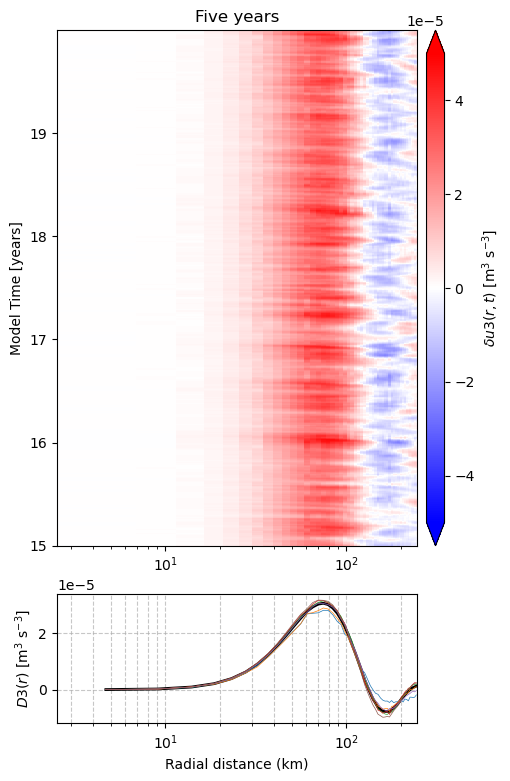

In [75]:
import matplotlib.gridspec as gridspec

# Example data
nrr, ntt = np.meshgrid(du_qg1_mean.dr.mean(dim='time'), np.arange(0, len(du_qg1_mean.time))+(15*365))

# Create figure and gridspec
fig = plt.figure(figsize=(5, 9))
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[4, 1], wspace=0.05, hspace=0.15)

# Main axes (both use the left column of the grid)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)

# Colorbar axis (right column of the top row)
cax = fig.add_subplot(gs[0, 1])

# --- Top panel: pcolormesh ---
pcm = ax1.pcolormesh(nrr * 1e-3, ntt/365, du_qg1_mean.du3,
                     cmap='bwr', vmin=-0.00005, vmax=0.00005, shading='auto')
ax1.set_xscale('log')
ax1.set_ylabel('Model Time [years]')
ax1.set_title('Five years')

# Colorbar outside the plot
fig.colorbar(pcm, cax=cax, orientation='vertical', 
             label='$\\delta u3(r,t)$ [m$^3$ s$^{-3}$]', extend='both')

# --- Bottom panel: semilogx ---
ax2.semilogx(du_qg1_mean.dr.mean('time') * 1e-3, du_qg1_mean.du3.mean('time'), color='k', linewidth=2)
ax2.semilogx(du_qg1_mean.dr.mean('time') * 1e-3, du_qg1_mean.du3.resample(time="1YE").mean().T, '-', linewidth=0.5)
ax2.grid(which='both', linestyle='--', alpha=0.7)
ax2.set_xlabel('Radial distance (km)')
ax2.set_ylabel('$D3(r)$ [m$^3$ s$^{-3}$]')

plt.show()

Text(0, 0.5, '$D3(r)$ [m$^3$ s$^{-3}$]')

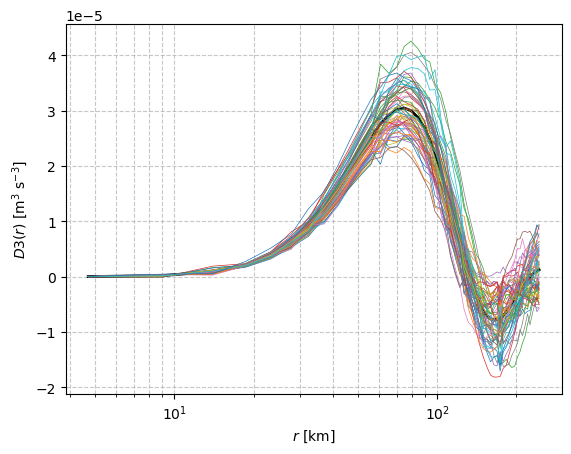

In [55]:
# --- Bottom panel: semilogx ---
plt.semilogx(du_qg1_mean.dr.mean('time') * 1e-3, du_qg1_mean.du3.mean('time'), color='k', linewidth=2)
plt.semilogx(du_qg1_mean.dr.mean('time') * 1e-3, du_qg1_mean.du3.resample(time="1ME").mean().T, '-', linewidth=0.5)
plt.grid(which='both', linestyle='--', alpha=0.7)
plt.xlabel('$r$ [km]')
plt.ylabel('$D3(r)$ [m$^3$ s$^{-3}$]')

In [118]:
# fileaver = '/data/SO3/manuelogv/MethodsKEFlux/spatialaverduLT/'

# # Open the NetCDF files using xarray's open_mfdataset (multi-file dataset)
# nc_files3 = fileaver +'*.nc'  #
# dult_aver = xr.open_mfdataset(nc_files3, engine='netcdf4', combine='by_coords')

# dult_aver = dult_aver.sortby('time').chunk({'time': 1825, 'dcorr': 2}).load()

In [119]:
# print('Size of Xarray dult_aver = {} MB'.format(int(dult_aver.nbytes/1e6)))
# dult_aver

In [120]:
# plt.semilogx(dult_aver.dr*1e-3, dult_aver.du3, '.k', markersize=2, alpha=0.01)
# plt.semilogx(dult_aver.dr.mean('time')*1e-3, dult_aver.du3.mean('time'), '.r', markersize=2)
# plt.xlabel('$r$ [km]')
# plt.ylabel('$\delta u3(\mathbf{r}, t)$ [m$^3$ s$^{-3}$]')

# Runs model and saves hourly outputs of the last month of the 20 year run

In [14]:
# Run with snapshots
year = 24*60*60*360. #seconds
tmax = 86400*365*10
tavent = tmax-86400*30

def run_simulation2(m, sampling_freq, tavestart):
    """
    m: pyqg model object
    sampling_freq: frequency in numerical timesteps in which to extract dataset
    """
    snapshots = []
    while eddy_model.t < eddy_model.tmax:
        if eddy_model.tc % sampling_freq == 0:
            if eddy_model.t > tavestart:
                ds=eddy_model.to_dataset().copy(deep=True)
                snapshots.append(ds)
        eddy_model._step_forward()
    return snapshots

eddy_model = pyqg.QGModel(nx=256.0, dt=3600.0, tmax=tmax, ntd=1, twrite=5000, 
                          tavestart=tavent, taveint= 1, 
                          beta=1.5e-11, rd=15000.0, delta=0.25, 
                          H1=500, U1=0.025, U2=0.0)

# Saves snapshots
snapshr = run_simulation2(eddy_model, 1, tavent) # Saves data 
# Convert to xarray data 
eddyrun_hr = xr.concat(snapshr, dim='time')

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 5000, Time: 1.80e+07, KE: 2.85e-07, CFL: 0.023
INFO: Step: 10000, Time: 3.60e+07, KE: 1.44e-06, CFL: 0.024
INFO: Step: 15000, Time: 5.40e+07, KE: 1.21e-05, CFL: 0.024
INFO: Step: 20000, Time: 7.20e+07, KE: 1.20e-04, CFL: 0.066
INFO: Step: 25000, Time: 9.00e+07, KE: 4.36e-04, CFL: 0.186
INFO: Step: 30000, Time: 1.08e+08, KE: 4.96e-04, CFL: 0.207
INFO: Step: 35000, Time: 1.26e+08, KE: 5.73e-04, CFL: 0.198
INFO: Step: 40000, Time: 1.44e+08, KE: 6.01e-04, CFL: 0.220
INFO: Step: 45000, Time: 1.62e+08, KE: 6.10e-04, CFL: 0.262
INFO: Step: 50000, Time: 1.80e+08, KE: 6.09e-04, CFL: 0.263
INFO: Step: 55000, Time: 1.98e+08, KE: 5.97e-04

In [18]:
# Removes variables
eddyrun_hr = eddyrun_hr.drop_vars(["qh", "uh", "vh", "ph", "dqhdt", "Ubg","Qy", "dqdt", "p", "ufull", "vfull"])

eddyrun_hr.to_netcdf('./QGModelRun1year_1hr.nc')